In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler

from time import time

### Load and prep data 

In [2]:
# read file the original data
td = pd.read_csv('data/12zpallnoagi_proc.csv')
print td.shape

# read Whole Foods zip codes
zcWF = pd.read_csv('data/ZipCodes_WholeFoods.csv')
print zcWF.shape

(27718, 74)
(394, 1)


In [3]:
zcWF.head()

,WholeFoodsZipCodes
0,1035
1,1701
2,1730
3,1778
4,1801


In [64]:
# separate the zip codes from the features
isZipCode = td.columns=='ZIPCODE'
zipcode = td[td.columns[ isZipCode]]
feat    = td[td.columns[~isZipCode]]

print "zip code: ", zipcode.shape
print "feat      ", feat.shape

# write to csv, no index
feat.to_csv('data/features_tax.csv', index_label=False)

zip code:  (27718, 1)
feat       (27718, 73)


In [65]:
feat.head()

,N1,MARS1,MARS2,MARS4,PREP,N2,NUMDEP,A00100,N00200,A00200,...,N09600,A09600,N06500,A06500,N10300,A10300,N11901,A11901,N11902,A11902
1,4930,1940,2150,720,2550,10170,3340,257563,4320,212053,...,30,70,3570,24332,3800,25545,750,2038,4020,10592
2,3370,1310,1100,880,1970,6800,2510,130344,2860,106936,...,0,0,2150,9178,2370,9809,420,984,2860,7970
3,1300,470,650,170,900,2790,920,59920,1090,49336,...,0,0,890,5043,970,5244,140,239,1130,3060
4,11800,4580,5250,1750,5510,25460,9310,630557,10340,513751,...,80,290,8120,59626,8870,63335,2130,6820,9290,23904
5,8660,3020,2870,2660,5060,19560,8460,384835,7470,261554,...,60,397,4750,38809,5230,41001,1060,3471,7290,21699


### Create log-transformed features

In [66]:
# log-transform
# copy data to new frame
feat_log = feat.copy()

#identify columns with neg. min. values for log-transform
#isMinValNeg=feat_log.min()<0
#col = feat_log.columns[isMinValNeg]
#print "columns with neg. min. value:", col.values 
# shift minimum to zero
#feat_log[col]= feat_log[col]-feat_log[col].min()
#print feat_log[col].min()

# shift all features to have minimum zero
feat_log= feat_log-feat_log.min()

feat_log = np.log10(feat_log+1)


### Z-normalized data

In [67]:
# zero mean, unit std
scaler = StandardScaler()

# copy data to new frame
feat_norm = feat_log.copy()

feat_norm = pd.DataFrame(scaler.fit_transform(feat_norm));


In [68]:
# load long.lat
zipInfo = pd.read_csv('data/free-zipcode-database-Primary.csv')

In [69]:
colToKeep=['Zipcode','Lat','Long']

zipInfo = zipInfo[colToKeep]

zipLoc = zipcode.copy()
tmp = np.squeeze(zipLoc)

zipLoc['Lat']=0
zipLoc['Long']=0

cnt1=0
cnt0=0
for k in range(len(tmp)):
    m = tmp[k] == zipInfo['Zipcode']
    if np.max(m):
        cnt1+=1
        #zipLoc.loc[k,'Lat']= zipInfo.loc[m,'Lat']
    else:
        cnt0+=0
        
print cnt1, cnt0



KeyError: 0

In [70]:
zipInfo.head()

,Zipcode,Lat,Long
0,705,18.14,-66.26
1,610,18.28,-67.14
2,611,18.28,-66.79
3,612,18.45,-66.73
4,601,18.16,-66.72


In [71]:
a=zipInfo.ix[:,1]
np.array(a)

array([ 18.14,  18.28,  18.28, ...,    nan,    nan,  44.05])

### Create zip code label for Whole Foods

In [72]:
tmp = np.squeeze(zcWF)

zipcode_label = zipcode.copy()
zipcode_label['WholeFoods']=0;

cnt1=0
cnt2=0
for zc in tmp:
    m = zc == zipcode.values[:,0]
    if np.max(m):
        zipcode_label.loc[m,'WholeFoods']=1
    else:
        print "Zip code not found: ", zc

print zipcode_label['WholeFoods'].sum()

labelWF = zipcode_label['WholeFoods']



Zip code not found:  80443
386


In [73]:
# write to csv, no index
zipcode_label.to_csv('data/zipCodeLabel_WholeFoods.csv', index_label=False)

In [74]:
zipcode_label.head()

,ZIPCODE,WholeFoods
1,35004,0
2,35005,0
3,35006,0
4,35007,0
5,35010,0


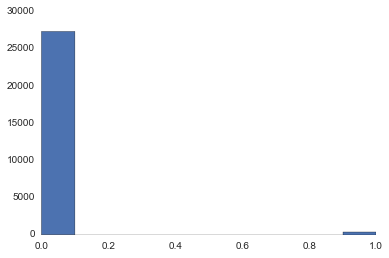

In [34]:
labelWF.hist()

### Feature importance

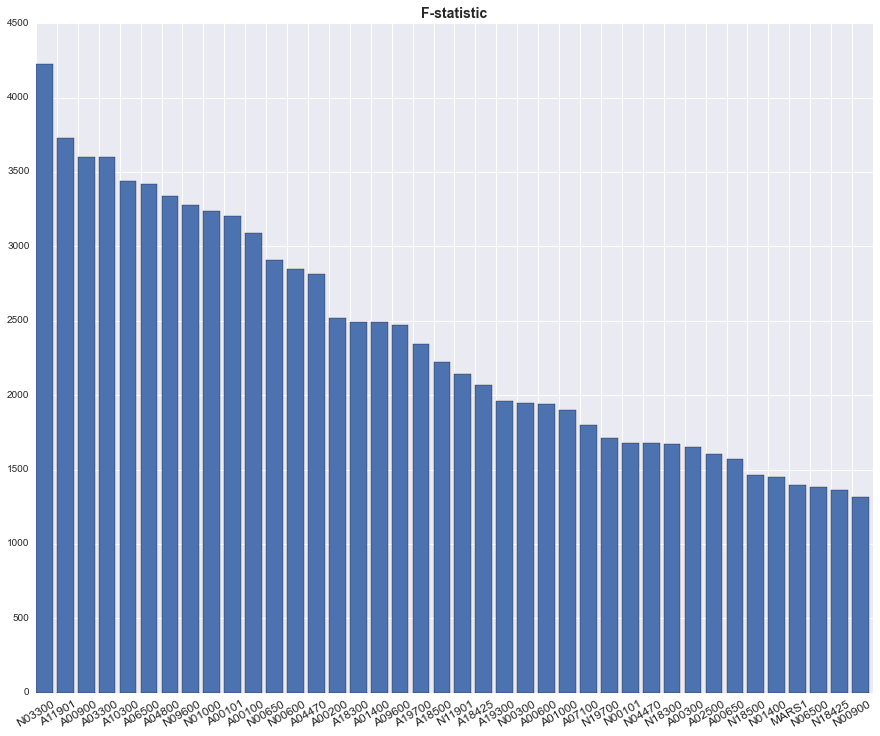

In [28]:
# 1. approach: F-statistic

from sklearn import feature_selection

X= pd.DataFrame(feat.copy(),columns=feat.columns)
y= labelWF

y = np.squeeze(y);
# show the first n-element
n= 40
nx = np.arange(n)

fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)

f =feature_selection.f_classif(X, y)[0]

# create sort index in descending order
sortIdx = np.argsort(f)[::-1]

ax.bar(nx, f[sortIdx[:n]])
ax.set_xticks(nx)
xtickNames = ax.set_xticklabels(X.columns[sortIdx[:n]])
_ = plt.setp(xtickNames, rotation=30, fontsize=12)

plt.title("F-statistic", fontweight='bold', fontsize=14);

#plt.savefig("figures/f-statistic.pdf")

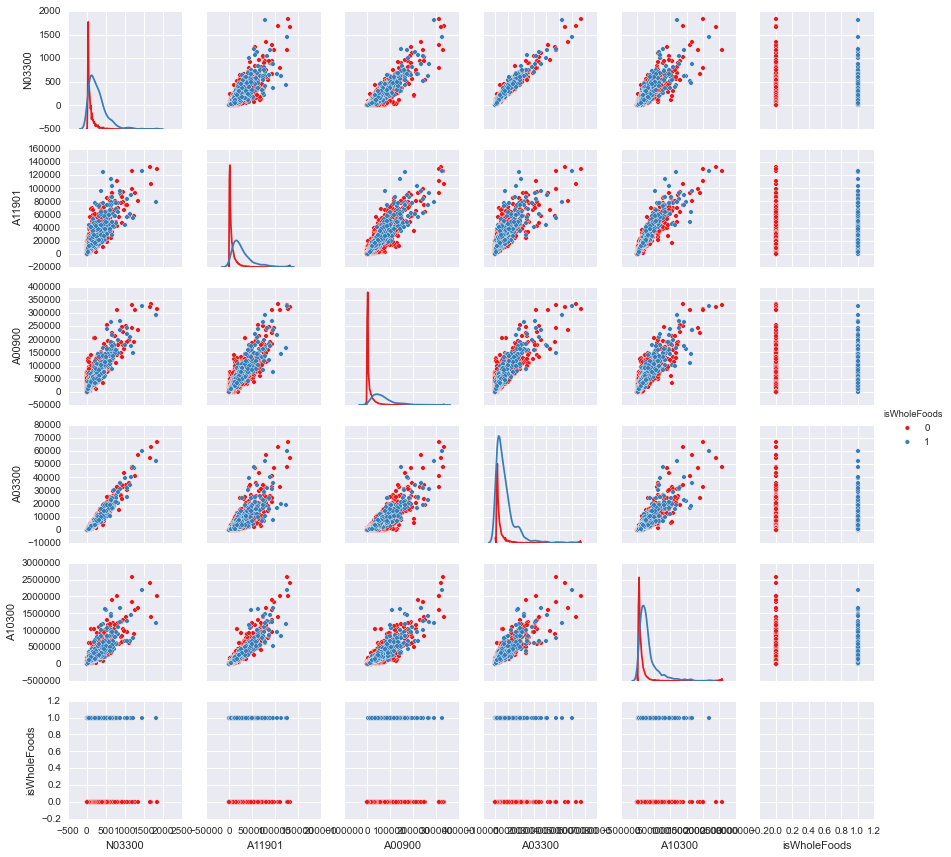

In [29]:
# scatter plot with log-transformed features

colIdx = list(X.columns[sortIdx[:5]])
data_show = X[colIdx].copy()
data_show['isWholeFoods']= pd.DataFrame(labelWF)
data_show.head()

#plt.figure(figsize=(15,12))
sns.pairplot(data_show, diag_kind='kde', hue='isWholeFoods', size=2, palette='Set1')

plt.savefig("figures/cross-corr.png",dpi=200)

In [10]:
plt.savefig?

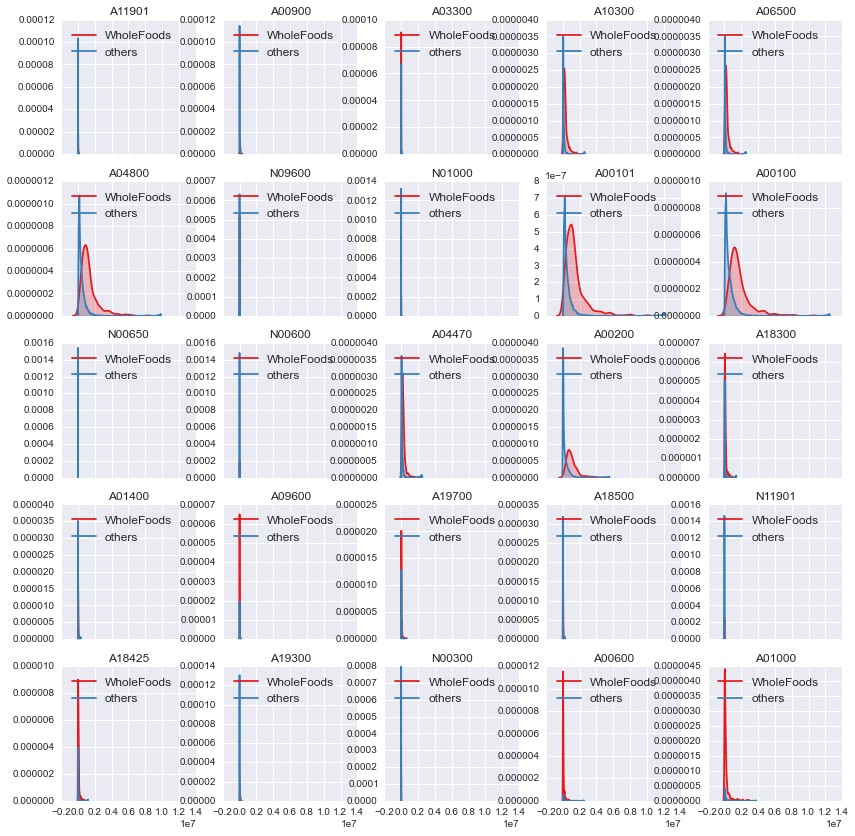

In [30]:
f, axList = plt.subplots(5, 5, sharex=True, figsize=(14, 14))
c1, c2 = sns.color_palette("Set1", 2)

colList = list(X.columns[sortIdx[:26]])

col = 0
for irow in range(5):
    for icol in range(5):
        col += 1
        tmpCol = colList[col]
        tmpAx = axList[irow,icol]
        #print irow, icol, tmpCol
        
        sns.kdeplot(X[tmpCol].loc[labelWF==1], shade=True, color=c1, label="WholeFoods", ax=tmpAx)
        sns.kdeplot(X[tmpCol].loc[labelWF==0], shade=True, color=c2, label="others",     ax=tmpAx)
        
        tmpAx.set_title(tmpCol)
        tmpAx.legend(fontsize=12,loc='upper left')
        
plt.savefig("figures/hist-dens.pdf")

In [237]:
tmp= feat_log.ix[:,:10]
tmp.shape

(27718, 10)

### PCA

In [79]:
# calculate PCA: data is log-transformed and scaled

from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=False)
scaler = StandardScaler()

# copy data to new frame
feat_pca = feat.copy()

feat_pca = scaler.fit_transform(feat_pca);

feat_pca = pca.fit_transform(feat_pca);


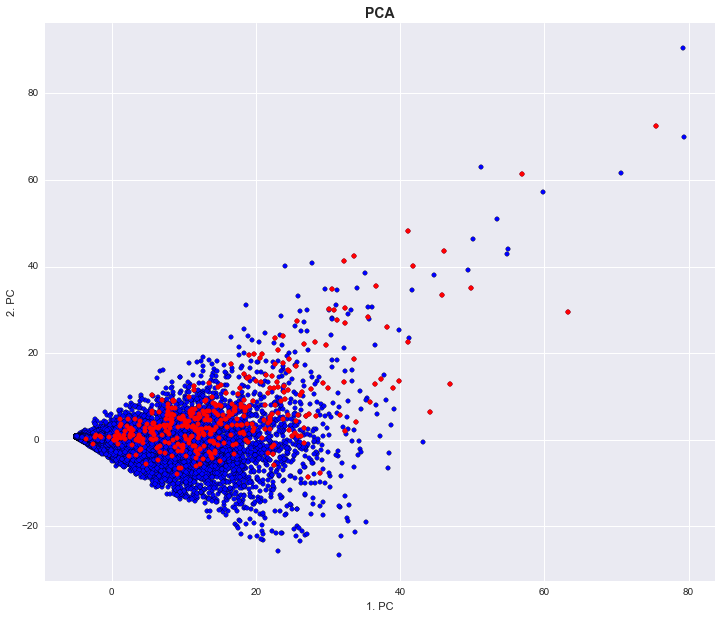

In [80]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(12,10))

cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
plt.scatter(feat_pca[:,0], feat_pca[:,1])
plt.scatter(feat_pca[labelWF.nonzero(),0], feat_pca[labelWF.nonzero(),1],
            color=cmap_bold.colors[0])

plt.title('PCA', fontweight='bold', fontsize=14);
plt.xlabel('1. PC')
plt.ylabel('2. PC')
plt.axis('tight')

plt.savefig("figures/pca.png",dpi=200)

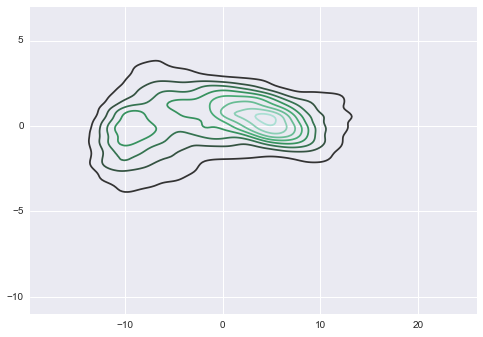

In [159]:
sns.kdeplot(feat_pca);

In [26]:
sns.jointplot?

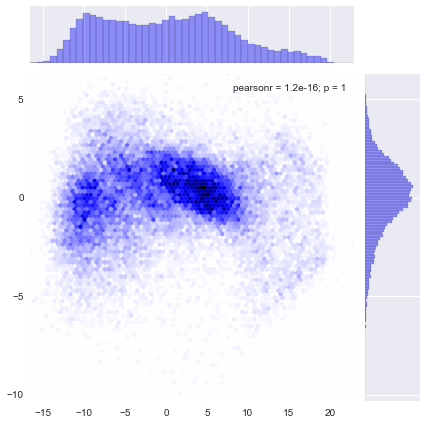

In [27]:
sns.jointplot(feat_pca[:,0],feat_pca[:,1],kind='hex',color='blue')
plt.savefig("figures/pca_log_jointplot.png",dpi=200)

(10386, 73) (10386,)
Isomap: 4.8e+02 sec


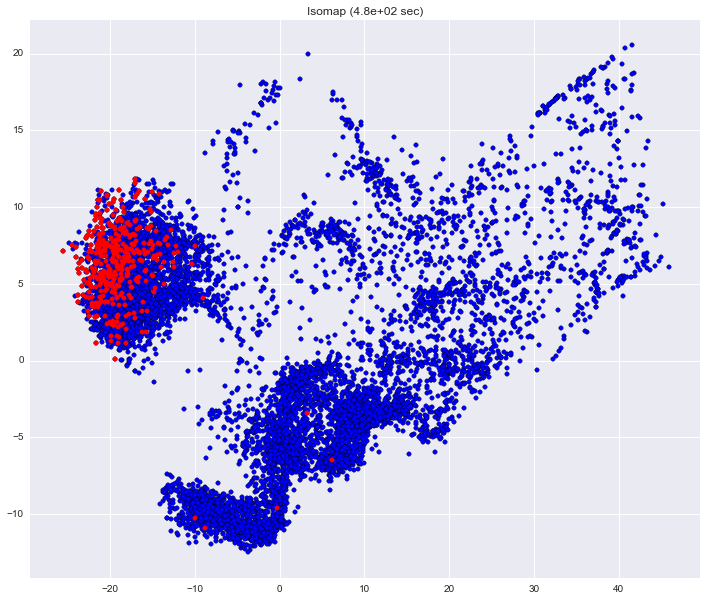

In [78]:
# calculate Isomap from subsample

from sklearn.manifold import Isomap

X = feat_log.copy()

N= 10000

x0 = X.loc[labelWF==0]
x1 = X.loc[labelWF==1]
#print x0.shape, x1.shape
x0=x0.loc[np.random.choice(x0.index, N , replace=False)]
#print x0.shape, x1.shape
X=x1.append(x0)
tmpLabel = pd.Series(np.zeros(X.shape[0]))
tmpLabel.ix[:x1.shape[0]]=1
print X.shape, tmpLabel.shape

t0 = time()
Y = Isomap(10, 2).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))

plt.figure(figsize=(12,10))
plt.scatter(Y[:, 0], Y[:, 1], c='blue', cmap=plt.cm.Spectral)
plt.scatter(Y[tmpLabel.nonzero(), 0], Y[tmpLabel.nonzero(), 1], color=cmap_bold.colors[0])

plt.title("Isomap (%.2g sec)" % (t1 - t0))
#ax.xaxis.set_major_formatter(NullFormatter())
#ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.savefig("figures/isomap_10k.png",dpi=200)

In [142]:
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})

In [19]:
plt.axis?
